<a href="https://colab.research.google.com/github/alibakh62/DeepFake-Kaggle/blob/master/notebook/colab/DeepFakeDetection_V11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Version 1.1

Main steps:



*   Videos -> frames (independent images)
*   Pre-trained convnets -> training only the top layer
*   Prediction on video -> Rolling moving average

**Changes from V1:**

*   Simplify the Xception model, removing all `Dense` layers except for the last one
*   Replace Xception with VGG16 for the conv-base model.

# Config and Imports

In [0]:
# from google.colab import drive
# drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
!pip install ipython-autotime

In [4]:
%load_ext autotime
%tensorflow_version 2.x
%matplotlib inline 

TensorFlow is already loaded. Please restart the runtime to change versions.


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
from tensorflow.keras.utils import get_file

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
# from tensorflow.keras.utils import np_utils
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import column_or_1d
import os
import shutil
from glob import glob
import math
import h5py
import matplotlib
import matplotlib.pyplot as plt
import random
#import cv2
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder
from skimage import io, transform
from sklearn.metrics import accuracy_score
from scipy import misc
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import cv2 as cv

time: 368 ms


# Models

### Importing pretrained convnets

In [6]:
from tensorflow.keras.applications import Xception, VGG16, InceptionResNetV2, DenseNet121

# conv_base = Xception(include_top=False)
# conv_base = VGG16(weights="imagenet", include_top=False)
# conv_base = InceptionResNetV2(include_top=False)
conv_base = DenseNet121(include_top=False)
# conv_base.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
time: 13.7 s


In [7]:
# freezing pretrained model
conv_base.trainable = False

# adding top layers
model = Sequential()
model.add(conv_base)
model.add(GlobalAveragePooling2D())
# model.add(Dense(1024, activation="selu"))
# model.add(Dense(265, activation="selu"))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________
time: 4.72 s


# DataPrep

### Config
***

In [8]:
# configs
MODELS_FOLDER = '/content/drive/My Drive/DeepFake/models'
BASE_FOLDER = '/content/drive/My Drive/DeepFake'
TRAIN_SAMPLE_VIDEOS = 'train_sample_videos'
TRAIN_INPUT = 'input'
TEST_VIDEOS = 'test_videos'
TRAIN_FRAMES_FOLDER = 'train_frames'
VALID_FRAMES_FOLDER = 'valid_frames'
TEST_FRAMES_FOLDER = 'test_frames'
DATA_FOLDER = 'data'
TRAIN_FOLDER = 'train'
VALID_FOLDER = 'valid'
TEST_FOLDER = 'test'
INPUT_SHAPE = (224, 224)
BATCH_SIZE = 128

time: 4.23 ms


### Meta data
***

In [0]:
def get_meta_from_json(path):
    df = pd.read_json(os.path.join(BASE_FOLDER, path, json_file))
    df = df.T
    return df

train_list = list(os.listdir(os.path.join(BASE_FOLDER, TRAIN_SAMPLE_VIDEOS)))
test_list = list(os.listdir(os.path.join(BASE_FOLDER, TEST_VIDEOS)))
json_file = [file for file in train_list if  file.endswith('json')][0]
meta_train_df = get_meta_from_json(TRAIN_SAMPLE_VIDEOS)
meta_train_df.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


time: 127 ms


### Converting videos into images
***

In [0]:
#@title Sample or All
sample = False #@param {type:"boolean"}
no_of_samples = 5 #@param {type:"integer"}

def get_frames(cap, name, dirname, resize=None):
    frameRate = cap.get(5) #frame rate
    count = 0
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            # storing the frames in a different folder
            if resize is not None:
                # image = np.array(tf.image.resize(frame, resize))
                image = cv.resize(frame, resize)
            else:
                image = frame
            if not os.path.isdir(os.path.join(BASE_FOLDER, dirname)):
                os.mkdir(os.path.join(BASE_FOLDER, dirname))
            count += 1
            fn = os.path.splitext(name)[0] + f"_frame{count}.jpg"
            file_path = os.path.join(BASE_FOLDER, dirname, fn)
            cv.imwrite(file_path, image)
    cap.release()

cnt_max = 2e10
if sample:
    cnt_max = no_of_samples

def walkdir(dirpath):
    for root, dirs, files in os.walk(dirpath):
        for name in files:
            if name != 'metadata.json':
                yield os.path.abspath(os.path.join(dirpath, name)), name

filescount = meta_train_df.index.nunique()

cnt = 1
X_train_full, y_train_full = [], []
for path, name in tqdm_notebook(walkdir(os.path.join(BASE_FOLDER, TRAIN_SAMPLE_VIDEOS)), total=filescount):
    if cnt <= cnt_max:
        cap = cv.VideoCapture(path)
        get_frames(cap, name, TRAIN_FRAMES_FOLDER)
        cnt += 1


time: 42min 54s


#### Getting train data & label
***

In [0]:
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import column_or_1d

images = glob(os.path.join(BASE_FOLDER, f"{TRAIN_FRAMES_FOLDER}/*.jpg"))
X_full, y_full = [], []
for i in tqdm_notebook(images):
    frame_name = i.split('/')[-1]
    image_name = frame_name.split("_")[0]
    label = 1
    if meta_train_df.loc[meta_train_df.index == image_name+'.mp4', "label"].values[0] == 'REAL':
        label = 0
    # reading frames
    img = image.load_img(i, target_size=(512, 512, 3))
    img = image.img_to_array(img)
    img = img/255
    X_full.append(img)
    y_full.append(label)

X = np.array(X_full)
y = column_or_1d(y_full)
print(X.shape)
print(y.shape)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")

### Converting videos to images (Keras)
***

#### Creating directories

In [0]:
# base folder
if not os.path.isdir(BASE_FOLDER):
    os.mkdir(BASE_FOLDER)

# data folder
data_dir = os.path.join(BASE_FOLDER, DATA_FOLDER)
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

# train folder
train_dir = os.path.join(data_dir, TRAIN_FOLDER)
if not os.path.isdir(train_dir):
    os.mkdir(train_dir)

if not os.path.isdir(os.path.join(train_dir, 'REAL')):
    os.mkdir(os.path.join(train_dir, 'REAL'))

if not os.path.isdir(os.path.join(train_dir, 'FAKE')):
    os.mkdir(os.path.join(train_dir, 'FAKE'))

# valid folder
valid_dir = os.path.join(data_dir, VALID_FOLDER)
if not os.path.isdir(valid_dir):
    os.mkdir(valid_dir)

if not os.path.isdir(os.path.join(valid_dir, 'REAL')):
    os.mkdir(os.path.join(valid_dir, 'REAL'))

if not os.path.isdir(os.path.join(valid_dir, 'FAKE')):
    os.mkdir(os.path.join(valid_dir, 'FAKE'))

# test folder
test_dir = os.path.join(data_dir, TEST_FOLDER)
if not os.path.isdir(test_dir):
    os.mkdir(test_dir)



time: 28.6 ms


#### Adding frames to train & validation folders

In [0]:
#@title Sample or All
sample = False #@param {type:"boolean"}
no_of_samples = 2 #@param {type:"integer"}

time: 1.38 ms


In [0]:
#@title Train/Validation Split
train_val_split = 0.8 #@param {type: "number"}

time: 912 µs


In [0]:
#TODO: resize not necessary here, will be done in ImageDataGenerator
def get_frames(cap, name, dirname, resize=None, test=False):
    frameRate = cap.get(5) #frame rate
    if not test:
        label = meta_train_df.loc[meta_train_df.index == name, "label"].values[0]
    count = 0
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            # storing the frames in a different folder
            if resize is not None:
                # image = np.array(tf.image.resize(frame, resize))
                image = cv.resize(frame, resize)
            else:
                image = frame
            count += 1
            fn = os.path.splitext(name)[0] + f"_frame{count}.jpg"
            if test:
                file_path = os.path.join(BASE_FOLDER, dirname, fn)
            else:
                file_path = os.path.join(BASE_FOLDER, dirname, label, fn)
            cv.imwrite(file_path, image)
    cap.release()

def walkdir(dirpath):
    for root, dirs, files in os.walk(dirpath):
        for name in files:
            if name != 'metadata.json':
                yield os.path.abspath(os.path.join(dirpath, name)), name

time: 13.6 ms


In [0]:
cnt_max = 2e10
if sample:
    cnt_max = no_of_samples

filescount = meta_train_df.index.nunique()
traincount = int(filescount * train_val_split)

cnt = 1
for path, name in tqdm_notebook(walkdir(os.path.join(BASE_FOLDER, TRAIN_SAMPLE_VIDEOS)), total=filescount):
    if cnt <= cnt_max:
        cap = cv.VideoCapture(path)
        if cnt <= traincount:
            dirname = os.path.join(DATA_FOLDER, TRAIN_FOLDER)
        else:
            dirname = os.path.join(DATA_FOLDER, VALID_FOLDER)
        get_frames(cap, name, dirname)
        cnt += 1

time: 37min


In [0]:
print(f"Total REAL train: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, TRAIN_FOLDER, 'REAL')))}")
print(f"Total FAKE train: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, TRAIN_FOLDER, 'FAKE')))}")
print(f"Total REAL valid: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, VALID_FOLDER, 'REAL')))}")
print(f"Total FAKE valid: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, VALID_FOLDER, 'FAKE')))}")

Total REAL train: 550
Total FAKE train: 2530
Total REAL valid: 297
Total FAKE valid: 1023
time: 41.8 s


#### Get More frame images

In [0]:
#@title All videos
input_folder_name = 'dfdc_train_part_0' #@param {type:"string"}

def get_meta_from_json(path):
    df = pd.read_json(os.path.join(BASE_FOLDER, path, json_file))
    df = df.T
    return df

train_list = list(os.listdir(os.path.join(BASE_FOLDER, TRAIN_INPUT, input_folder_name)))
json_file = [file for file in train_list if  file.endswith('json')][0]
meta_train_df = get_meta_from_json(os.path.join(TRAIN_INPUT, input_folder_name))

no_of_samples = 20
sample = False

cnt_max = 2e10
if sample:
    cnt_max = no_of_samples

train_val_split = 0.8
filescount = meta_train_df.index.nunique()
traincount = int(filescount * train_val_split)

cnt = 1
for path, name in tqdm_notebook(walkdir(os.path.join(BASE_FOLDER, TRAIN_INPUT, input_folder_name)), total=filescount):
    if cnt <= cnt_max:
        cap = cv.VideoCapture(path)
        if cnt <= traincount:
            dirname = os.path.join(DATA_FOLDER, TRAIN_FOLDER)
        else:
            dirname = os.path.join(DATA_FOLDER, VALID_FOLDER)
        get_frames(cap, name, dirname)
        cnt += 1


time: 3h 23min 48s


### Image generator for Keras

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(BASE_FOLDER, DATA_FOLDER, TRAIN_FOLDER)
valid_dir = os.path.join(BASE_FOLDER, DATA_FOLDER, VALID_FOLDER)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 17752 images belonging to 2 classes.
Found 4257 images belonging to 2 classes.
time: 689 ms


In [0]:
valid_generator.class_indices

{'FAKE': 0, 'REAL': 1}

time: 2.62 ms


In [0]:
# for data_batch, label_batch in train_generator:
#     print(f"data batch shape: {data_batch.shape}")
#     print(f"label batch shape: {label_batch.shape}")
#     break

data batch shape: (32, 224, 224, 3)
label batch shape: (32,)
time: 24.7 s


# Training

### Fitting: default

In [0]:
# checkpoints
CHECKPOINT = 'xception_v1.hDF5'
weights_path = os.path.join(MODELS_FOLDER, CHECKPOINT)
from keras.callbacks import ModelCheckpoint
ckp = ModelCheckpoint(weights_path, save_best_only=True, monitor='val_loss', mode='min')

time: 128 ms


Using TensorFlow backend.


In [0]:
# compiling the model
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

time: 71.3 ms


In [0]:
# training the model
model.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid), callbacks=[ckp], batch_size=16)

### Fitting: with generators

#### Keras

In [10]:
from datetime import datetime
timestamp = datetime.now().strftime(format="%Y%m%d_%H%M%S")
CHECKPOINT = f"densenet121_v2_17K_frames_{timestamp}.h5"
weights_path = os.path.join(MODELS_FOLDER, CHECKPOINT)

from keras.callbacks import ModelCheckpoint
ckp = ModelCheckpoint(weights_path, save_best_only=True, monitor='val_loss', mode='min')

# compiling the model
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
time: 169 ms


Using TensorFlow backend.


In [0]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//BATCH_SIZE,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples//BATCH_SIZE,
    callbacks=[ckp])

Epoch 1/10
138/138 [==============================] - 12937s 94s/step - loss: 0.3156 - acc: 0.9030 - val_loss: 0.3561 - val_acc: 0.8778
Epoch 2/10
 84/138 [=================>............] - ETA: 50:35 - loss: 0.2728 - acc: 0.9174

In [0]:
model.save(weights_path)

#### Training vs. Validation Loss

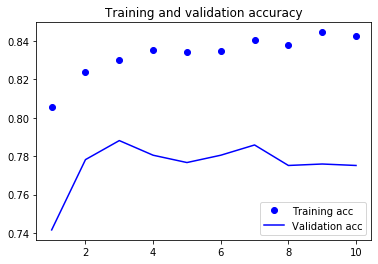

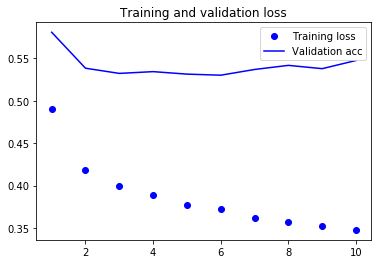

time: 1.27 s


In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation acc')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Confusion Matrix

#### functions

In [0]:
# model = models.load_model(os.path.join(MODELS_FOLDER, 'xception_v1_20200309_190640.h5'))
# model.summary()

['dense_2']

time: 2.67 ms


In [0]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    import seaborn as sn
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.set(rc={'figure.figsize':(8,8)})
    sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size=20)
    plt.xlabel('Predicted label', size=20)
    plt.xticks(np.arange(2), ['REAL', 'FAKE'], size=16)
    plt.yticks(np.arange(2), ['REAL', 'FAKE'], size=16)
    plt.ylim([2, 0])
    plt.show()

time: 9.83 ms


In [0]:
# predicting videos
def predict_on_videos(model, frames_folder):
    images = glob(os.path.join(BASE_FOLDER, f"{frames_folder}/*.jpg"))
    framescount = len(os.listdir(os.path.join(BASE_FOLDER, frames_folder)))
    predictions = []
    for i in tqdm_notebook(images, total=framescount):
        video_prediction = {}
        framename = os.path.splitext(i.split('/')[-1])[0]
        videoname = framename.split('_')[0] + '.mp4'
        video_prediction.update({"filename": videoname})
        img = image.load_img(i, target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1], 3))
        img = image.img_to_array(img)
        img = img/255
        img_ = np.expand_dims(img, axis=0)
        prob = 1 - model.predict_proba(img_)[0][0]
        pred_class = 1 - model.predict_classes(img_)[0][0]
        video_prediction.update({"probability": prob})
        video_prediction.update({"pred_class": pred_class})
        predictions.append(video_prediction)
    return predictions

time: 10.6 ms


#### Copying frames into a single folder

In [0]:
import shutil

valid_dir = os.path.join(BASE_FOLDER, DATA_FOLDER, VALID_FOLDER)
src_folder_fake = os.path.join(valid_dir, 'FAKE')
src_folder_real = os.path.join(valid_dir, 'REAL')
dst_folder = os.path.join(BASE_FOLDER, VALID_FRAMES_FOLDER)

# first remove all previous files (if there's any)
if os.path.isdir(dst_folder):
    for fn in os.listdir(dst_folder):
        if fn.endswith('.jpg'):
            os.unlink(os.path.join(dst_folder, fn))

#TODO: this takes long time, maybe doing it manually is faster
# copying files over to a single folder
for f in os.listdir(src_folder_fake):
    shutil.copy(os.path.join(src_folder_fake, f), dst_folder)

for f in os.listdir(src_folder_real):
    shutil.copy(os.path.join(src_folder_real, f), dst_folder)

time: 10min 12s


#### Getting predictions

In [0]:
# getting predictions on the validation data
valid_frames_dir = os.path.join(BASE_FOLDER, VALID_FRAMES_FOLDER)
predictions_valid = predict_on_videos(model, valid_frames_dir)


time: 22min 9s


In [0]:
predictionsdf_valid = pd.DataFrame(predictions_valid)
predictionsdf_valid["probability"].astype('float')
predictionsdf_valid.head()

,filename,probability,is_fake
0,ahfazfbntc.mp4,0.999648,1
1,ahfazfbntc.mp4,0.995557,1
2,ahfazfbntc.mp4,0.995658,1
3,ahfazfbntc.mp4,0.999478,1
4,ahfazfbntc.mp4,0.997249,1


time: 15.9 ms


In [0]:
predictionsdf_valid["pred_class"].value_counts(normalize=True)

1    0.941667
0    0.058333
Name: is_fake, dtype: float64

time: 17.9 ms


In [0]:
aggregations = {
    'probability': ["mean", "std"],
    'pred_class': "sum"
}
renames = {
    "mean": "prob_avg",
    "std": "prob_std",
    "sum": "total_fake_votes"
}

tmp = pd.DataFrame(predictionsdf_valid.groupby('filename')
                                .agg(aggregations)
                                .rename(columns=renames))
tmp.columns = tmp.columns.droplevel(level=0)
tmp.reset_index(inplace=True)
tmp.head()

,filename,prob_avg,prob_std,total_fake_votes
0,acqfdwsrhi.mp4,0.996693,0.005335,11
1,aelfnikyqj.mp4,0.877545,0.037042,11
2,ahfazfbntc.mp4,0.997051,0.002333,11
3,aipfdnwpoo.mp4,0.999949,0.000091,11
4,ajwpjhrbcv.mp4,0.999666,0.000130,11


time: 28 ms


In [0]:
tmp0 = tmp.groupby("total_fake_votes").agg({"prob_avg": "mean", "prob_std": "mean"})
tmp0.columns = ["mean_prob", "mean_prob_std"]
tmp0["mean_plus_std"] = tmp0["mean_prob"] + tmp0["mean_prob_std"]
tmp0["mean_minus_std"] = tmp0["mean_prob"] - tmp0["mean_prob_std"]
tmp0

,mean_prob,mean_prob_std,mean_plus_std,mean_minus_std
total_fake_votes,,,,
2,0.387535,0.138335,0.525869,0.249200
3,0.410354,0.101335,0.511689,0.309019
4,0.452104,0.243705,0.695808,0.208399
6,0.600495,0.193977,0.794472,0.406518
7,0.602725,0.266941,0.869666,0.335784
8,0.697030,0.265710,0.962741,0.431320
9,0.764262,0.264376,1.028637,0.499886
10,0.789442,0.185566,0.975008,0.603876
11,0.973242,0.021231,0.994473,0.952011


time: 21.3 ms


In [0]:
preds = predictionsdf_valid.set_index('filename')
confmat = preds.merge(meta_train_df, left_index=True, right_index=True)
confmat["true_class"] = 0
confmat.loc[confmat["label"] == 'FAKE', "true_class"] = 1
confmat.head()

,probability,is_fake,label,split,original,true_class
acqfdwsrhi.mp4,0.997966,1,FAKE,train,ccfoszqabv.mp4,1
acqfdwsrhi.mp4,0.999062,1,FAKE,train,ccfoszqabv.mp4,1
acqfdwsrhi.mp4,0.997395,1,FAKE,train,ccfoszqabv.mp4,1
acqfdwsrhi.mp4,0.999952,1,FAKE,train,ccfoszqabv.mp4,1
acqfdwsrhi.mp4,0.981442,1,FAKE,train,ccfoszqabv.mp4,1


time: 26.1 ms


True positive =  17
False positive =  280
False negative =  60
True negative =  963




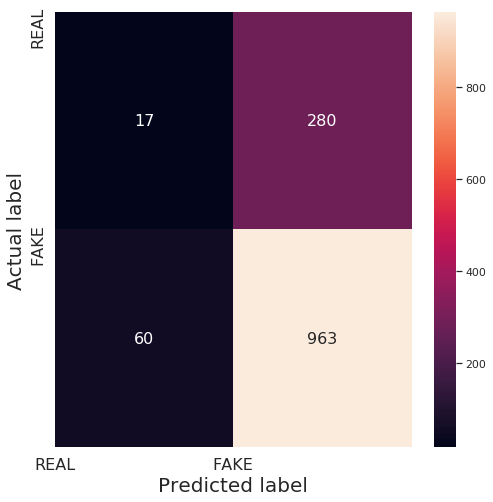

time: 254 ms


In [0]:
ypreds = confmat["pred_class"].values
ytrue = confmat["true_class"].values
print_confusion_matrix(ytrue, ypreds)

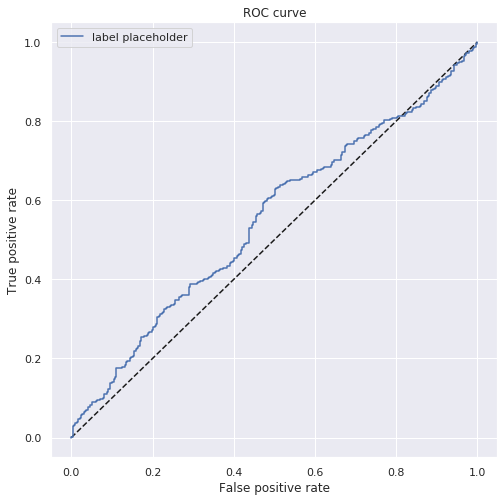

time: 337 ms


In [0]:
yprobs = confmat["probability"].values
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(ytrue, yprobs)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='label placeholder')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
# AUC
print(f"AUC: {roc_auc_score(ytrue, yprobs)}")

AUC: 0.5493481573637976
time: 3.72 ms


In [0]:
from sklearn.metrics import accuracy_score, log_loss

print(f"accuracy: {accuracy_score(ytrue, ypreds)}")
print(f"log loss: {log_loss(ytrue, ypreds)}")

accuracy: 0.7424242424242424
log loss: 8.896521107234914
time: 4.67 ms


# Prediction

### Converting test videos into frames

In [0]:
filescount = len(os.listdir(os.path.join(BASE_FOLDER, TEST_VIDEOS)))

if not os.path.isdir(os.path.join(BASE_FOLDER, TEST_FRAMES_FOLDER)):
    os.mkdir(os.path.join(BASE_FOLDER, TEST_FRAMES_FOLDER))

for path, name in tqdm_notebook(walkdir(os.path.join(BASE_FOLDER, TEST_VIDEOS)), total=filescount):
    cap = cv.VideoCapture(path)
    get_frames(cap, name, TEST_FRAMES_FOLDER, test=True)


time: 51min 27s


In [0]:
# number of test frames
print(len(os.listdir(os.path.join(BASE_FOLDER, TEST_FRAMES_FOLDER))))

4367
time: 40.9 ms


In [0]:
# predicting for one frame
images = glob(os.path.join(BASE_FOLDER, f"{TEST_FRAMES_FOLDER}/*.jpg"))

for i in images:
    img = image.load_img(i, target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1], 3))
    img = image.img_to_array(img)
    img = img/255
    break

img_ = np.expand_dims(img, axis=0)
print(f"Predicted Probability (fake=1): {model.predict_proba(img_)[0][0]}")
print(f"Predicted Class: {model.predict_classes(img_)[0][0]}")

Predicted Probability (fake=1): 0.16841162741184235
Predicted Class: 0
time: 86.6 ms


### Getting Predictions



1.   Generate predictions (probability) for each frame
2.   Get the average probability frames for each video
3.   Predict classes

**NOTE:** For each video, in addition to the average, get the std, min, and max.



In [0]:
predictions = predict_on_videos(model, TEST_FRAMES_FOLDER)


time: 1h 11min 1s


In [0]:
predictionsdf = pd.DataFrame(predictions)
predictionsdf["probability"].astype('float')
predictionsdf.head()

,filename,probability,is_fake
0,wcvsqnplsk.mp4,0.174893,0
1,wcvsqnplsk.mp4,0.012918,0
2,wcvsqnplsk.mp4,0.011358,0
3,wcvsqnplsk.mp4,0.069763,0
4,wcvsqnplsk.mp4,0.031704,0


time: 20.5 ms


In [0]:
aggregations = {
    'probability': ["mean", "std"],
    'pred_class': "sum"
}
renames = {
    "mean": "prob_avg",
    "std": "prob_std",
    "sum": "total_fake_votes"
}

tmp = pd.DataFrame(predictionsdf.groupby('filename')
                                .agg(aggregations)
                                .rename(columns=renames))
tmp.columns = tmp.columns.droplevel(level=0)
tmp.reset_index(inplace=True)
tmp.head()

,filename,prob_avg,prob_std,total_fake_votes
0,aassnaulhq.mp4,0.422539,0.216485,4
1,aayfryxljh.mp4,0.081732,0.049809,0
2,acazlolrpz.mp4,0.049928,0.040868,0
3,adohdulfwb.mp4,0.011888,0.008270,0
4,ahjnxtiamx.mp4,0.003309,0.003416,0


time: 41.4 ms


In [0]:
fn = os.path.splitext(CHECKPOINT)[0] + '.csv'
tmp.to_csv(os.path.join(BASE_FOLDER, 'predictions', fn))

time: 10.1 ms


In [0]:
preds = pd.read_csv('/content/drive/My Drive/DeepFake/predictions/xception_v1_20200309_190640.csv')
preds.head()

,Unnamed: 0,filename,prob_avg,prob_std,total_fake_votes
0,0,aassnaulhq.mp4,0.422539,0.216485,4
1,1,aayfryxljh.mp4,0.081732,0.049809,0
2,2,acazlolrpz.mp4,0.049928,0.040868,0
3,3,adohdulfwb.mp4,0.011888,0.008270,0
4,4,ahjnxtiamx.mp4,0.003309,0.003416,0


time: 467 ms


In [0]:
preds["total_fake_votes"].value_counts(ascending=True)

9       2
11      3
8       4
3       5
10      5
5       7
7       7
6      11
4      12
2      15
1      33
0     293
Name: total_fake_votes, dtype: int64

time: 4.95 ms


In [0]:
tmp0 = preds.groupby("total_fake_votes").agg({"prob_avg": "mean", "prob_std": "mean"})
tmp0.columns = ["mean_prob", "mean_prob_std"]
tmp0["mean_plus_std"] = tmp0["mean_prob"] + tmp0["mean_prob_std"]
tmp0["mean_minus_std"] = tmp0["mean_prob"] - tmp0["mean_prob_std"]
tmp0

,mean_prob,mean_prob_std,mean_plus_std,mean_minus_std
total_fake_votes,,,,
0,0.040710,0.039444,0.080154,0.001266
1,0.150052,0.190203,0.340255,-0.040151
2,0.252342,0.243074,0.495415,0.009268
3,0.318881,0.316369,0.635250,0.002511
4,0.372307,0.260626,0.632933,0.111681
5,0.460388,0.224052,0.684441,0.236336
6,0.487586,0.251518,0.739104,0.236069
7,0.553105,0.272037,0.825142,0.281067
8,0.598509,0.246898,0.845407,0.351611


time: 22.4 ms
